# Test timing of AssignResources on stand-alone SDP

This notebook times the repeated invocation of the AssignResources command on the SDP. 

Import modules

In [1]:
import json
import os
import time
import random
from datetime import date
from tango import DeviceProxy

Set the namespace containing the SDP you want to use

In [2]:
namespace = "my-namespace"

Set the `TANGO_HOST` environment variable so the Tango client can connect

In [3]:
os.environ["TANGO_HOST"] = f"databaseds-tango-base.{namespace}:10000"

Connect to the first subarray

In [4]:
 s1 = DeviceProxy("test-sdp/subarray/01")

Turn subarray off if it is not already off.

In [5]:
if s1.state().name != "OFF":
    s1.Off()

Turn subarray on again.

In [6]:
s1.On()

The state should be "ON" and the obsState should be "EMPTY"

In [7]:
s1.State().name, s1.obsState.name

('ON', 'EMPTY')

Define function to generate an AssignResources configuration string with unique IDs.

The configuration contains one processing block to run the `test-receive-addresses` processing script.

In [8]:
def generate_config(number: int):
    # Generate EB and PB IDs.
    generator = "test"
    today = date.today().strftime("%Y%m%d")
    rand = random.randint(0, 99)
    eb_id = f"eb-{generator}-{today}-{rand:02d}{number:03d}"
    pb_id = f"pb-{generator}-{today}-{rand:02d}{number:03d}"
    # AssignResources config as dict
    config = {
      "interface": "https://schema.skao.int/ska-sdp-assignres/0.4",
      "resources": {
        "receptors": ["SKA001", "SKA002", "SKA003", "SKA004"]
      },
      "execution_block": {
        "eb_id": eb_id,
        "context": {},
        "max_length": 3600.0,
        "beams": [
          {"beam_id": "vis0", "function": "visibilities"}
        ],
        "scan_types": [
          {
            "scan_type_id": ".default",
            "beams": {
              "vis0": {
                "channels_id": "vis_channels",
                "polarisations_id": "all"
              }
            }
          },
          {
            "scan_type_id": "target:a",
            "derive_from": ".default",
            "beams": {
              "vis0": {
                "field_id": "field_a"
              }
            }
          }
        ],
        "channels": [
          {
            "channels_id": "vis_channels",
            "spectral_windows": [
              {
                "spectral_window_id":"fsp_1_channels",
                "count": 4,
                "start": 0,
                "stride": 2,
                "freq_min": 350000000.0,
                "freq_max": 368000000.0,
                "link_map": [[0, 0], [200, 1], [744, 2], [944, 3]]
              }
            ]
          }
        ],
        "polarisations": [
          {
            "polarisations_id": "all",
            "corr_type": ["XX", "XY", "YX", "YY"]
          }
        ],
        "fields": [
          {
            "field_id": "field_a",
            "phase_dir": {
              "ra": [123.0],
              "dec": [-60.0],
              "reference_time": "...",
              "reference_frame": "ICRF3"
            },
            "pointing_fqdn": "..."
          }
        ],
      },
      "processing_blocks": [
        {
          "pb_id": pb_id,
          "script": {"kind": "realtime", "name": "test-receive-addresses", "version": "0.9.0"},
        },
      ],
    }
    # Convert config to string
    return json.dumps(config)

Parameters for test:
- `nattempt` - number of attempts
- `first` - number to use in IDs in first test, incremented at each attempt
- `timeout` - timeout for waiting for AssignResources (in seconds)
- `interval` - interval for testing obsState (in seconds)

In [9]:
nattempt = 100
first = 0
timeout = 60.0
interval = 0.1

Run the test

In [ ]:
time_taken = []

for i in range(nattempt):
    # Number to use in IDs
    number = first + i
    # Get AssignResources configuration
    config = generate_config(number)    
    # Call AssignResources
    s1.AssignResources(config)
    # Wait for obsState to reach IDLE
    t0 = time.time()
    while time.time() < t0 + timeout and s1.obsState.name != "IDLE":
        time.sleep(interval)
    deltat = time.time() - t0
    print(f"Attempt {i}: AssignResources took {deltat} s")
    time_taken.append(deltat)
    # End EB and the associated PB
    s1.End()
    # Release all resources
    s1.ReleaseAllResources()

Plot the results

In [37]:
from matplotlib import pyplot as plt

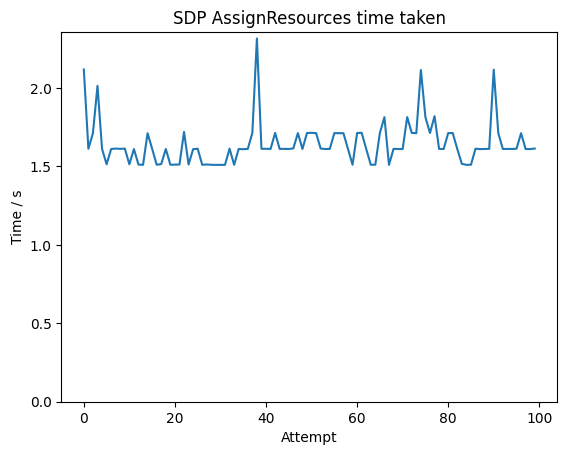

In [38]:
plt.plot(time_taken)
plt.title("SDP AssignResources time taken")
plt.ylim(0, None)
plt.xlabel("Attempt")
plt.ylabel("Time / s")
plt.savefig("sdp_assignresources_timing.png")